In [75]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [66]:
import lightkurve as lk

In [19]:
search_result = lk.search_targetpixelfile('GD 394', mission='TESS', sector=15)

In [20]:
search_result

SearchResult containing 1 data products.

target_name                     productFilename                        description     distance
----------- ------------------------------------------------------- ------------------ --------
  259773610 tess2019226182529-s0015-0000000259773610-0151-s_tp.fits Target pixel files      0.0

In [21]:
tpf = search_result.download(quality_bitmask='default')

In [22]:
tpf

TessTargetPixelFile(TICID: 259773610)

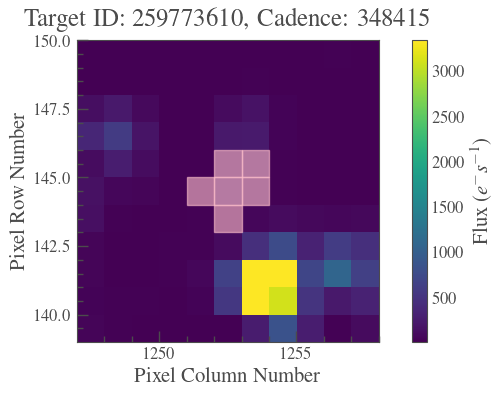

In [62]:
#%matplotlib inline
tpf.plot(aperture_mask=tpf.pipeline_mask);



In [24]:
lc = tpf.to_lightcurve()

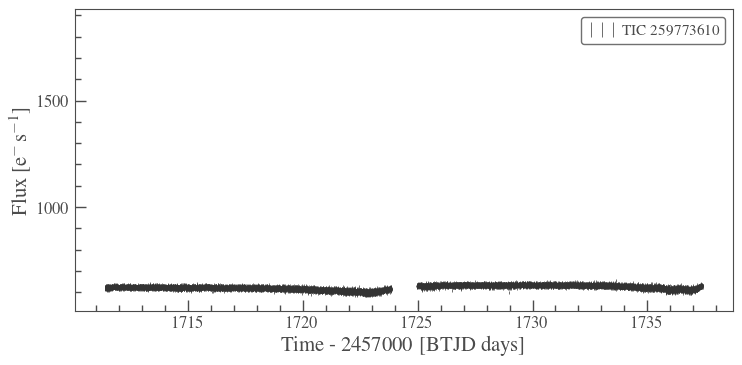

In [76]:
lc.errorbar();

In [3]:


#aperture_mask = tpf.create_threshold_mask(threshold=20)

# Plot that aperture
#tpf.plot(aperture_mask=aperture_mask);



In [18]:
#lc = tpf.to_lightcurve(aperture_mask=aperture_mask)

In [63]:
#lc.errorbar();

In [4]:
search_result = lk.search_lightcurvefile('GD 394', mission='TESS', sector=15)

In [5]:
search_result

SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  259773610 tess2019226182529-s0015-0000000259773610-0151-s_lc.fits Light curves      0.0

In [60]:
lcf = lk.search_lightcurvefile('GD 394', mission='TESS', sector=15).download()

In [87]:
lcf.errorbar;

In [78]:
hdul = fits.open('MAST_2019-10-28T1623/TESS/tess2019226182529-s0015-0000000259773610-0151-s/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits')

In [79]:
data = hdul[1].data

In [80]:
data.dtype.names

('TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2')

<ErrorbarContainer object of 3 artists>

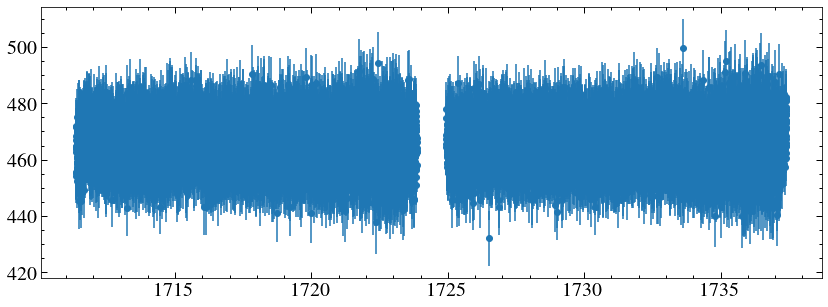

In [85]:
plt.errorbar(data['TIME'], data['PDCSAP_FLUX'], yerr=data['PDCSAP_FLUX_ERR'], ls='none', marker='o')
#plt.errorbar(data['TIME'], data['SAP_FLUX'], yerr=data['SAP_FLUX_ERR'], ls='none', marker='o')

In [128]:
from astropy.timeseries import LombScargle


1.1421546939243226


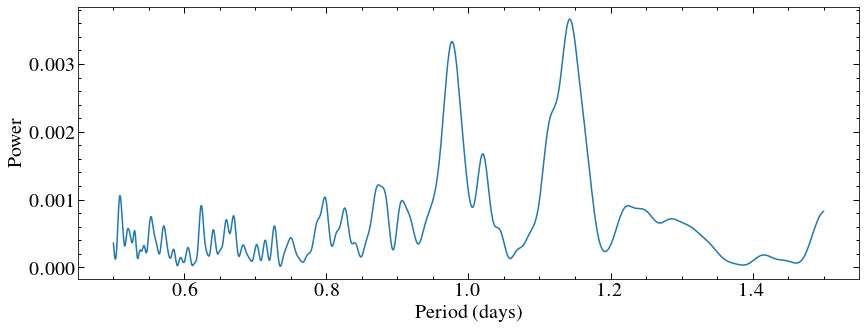

In [185]:
time = data['TIME'][np.isnan(data['PDCSAP_FLUX'])==False]
percent_change = data['PDCSAP_FLUX'][np.isnan(data['PDCSAP_FLUX'])==False]/np.median(data['PDCSAP_FLUX'][np.isnan(data['PDCSAP_FLUX'])==False])*100
ne = data['PDCSAP_FLUX_ERR'][np.isnan(data['PDCSAP_FLUX'])==False]/np.median(data['PDCSAP_FLUX'][np.isnan(data['PDCSAP_FLUX'])==False])*100
frequency, power = LombScargle(time, percent_change, 1/ne, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.5, samples_per_peak=50)
period = 1 / frequency[np.argmax(power)]

plt.plot(1 / frequency, power)
plt.xlabel("Period (days)")
plt.ylabel("Power");
print(period)

In [161]:
#tf = time/period %1 
#plt.errorbar(tf, percent_change, yerr=ne, ls='none')

What about the other period? Divide into 6 day chunks, see if it persists? Also check nearby stars 

In [159]:
#num_step =3
#step =int(len(time)/num_step)
#for i in range(num_step):
 #   ti = time[i*step:i*step+step]
  #  fi = percent_change[i*step:i*step+step]
  #  frequency, power = LombScargle(ti, fi, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.5, samples_per_peak=10)
   # plt.plot(1 / frequency, power)
   # plt.xlabel("Period (days)")
   # plt.ylabel("Power")
   # plt.show()

    

Inconclusive. What about that bright star nearby

In [126]:
#lc2 = fits.getdata('MAST_2019-10-28T1652/TESS/tess2019226182529-s0015-0000000387572309-0151-s/tess2019226182529-s0015-0000000387572309-0151-s_lc.fits',1)

In [160]:
#time2 = lc2['TIME'][np.isnan(lc2['PDCSAP_FLUX'])==False]
#percent_change2 = lc2['PDCSAP_FLUX'][np.isnan(lc2['PDCSAP_FLUX'])==False]/np.median(lc2['PDCSAP_FLUX'][np.isnan(lc2['PDCSAP_FLUX'])==False])
#ne = data['PDCSAP_FLUX_ERR'][np.isnan(data['PDCSAP_FLUX'])==False]/np.median(data['PDCSAP_FLUX'][np.isnan(data['PDCSAP_FLUX'])==False])
#frequency2, power2 = LombScargle(time2, percent_change2, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.5, samples_per_peak=10)
#period2 = 1 / frequency2[np.argmax(power2)]

#plt.plot(1 / frequency2, power2)
#plt.plot(1 / frequency, power)
#plt.xlabel("Period (days)")
#plt.ylabel("Power");
#print(period2)

Parameter('mean', value=0.9775412837841057) 0.00038546125027166003
Parameter('mean', value=1.1395300099243286) 0.0004449871940365642


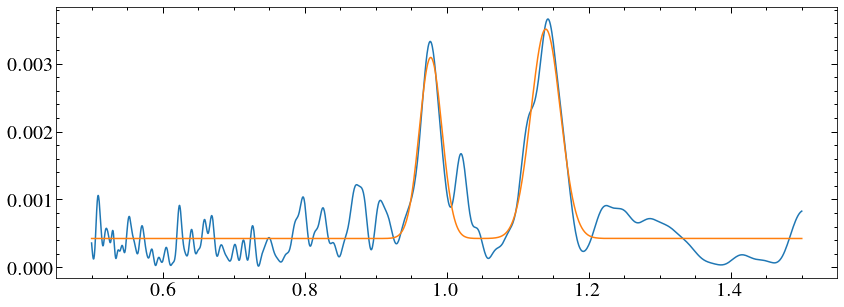

In [189]:
from astropy.modeling import models, fitting
fitter = fitting.LevMarLSQFitter()

plt.plot(1 / frequency, power)
gg_init = models.Gaussian1D(0.004, 0.95,0.01) + models.Gaussian1D(0.004, 1.14,0.01)+models.Const1D(0)
gg_fit=fitter(gg_init, 1 / frequency, power, maxiter=10000)
plt.plot(1/frequency, gg_fit(1/frequency))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(gg_fit[0].mean, fit_e[1])
print(gg_fit[1].mean, fit_e[4])

Parameter('mean', value=1.1391327929283268, bounds=[1.139, 1.15]) 0.001588049003437508


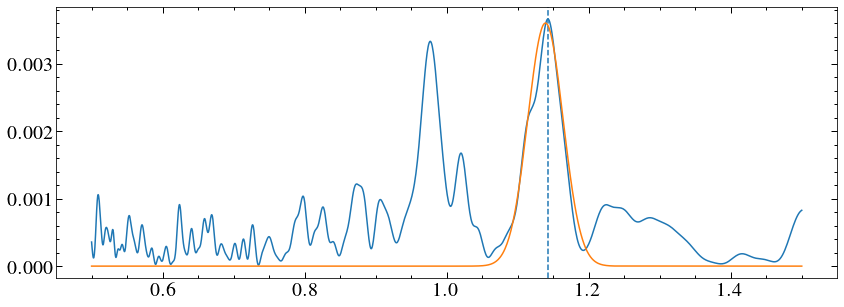

In [219]:
from astropy.modeling import models, fitting
fitter = fitting.LevMarLSQFitter()

plt.plot(1 / frequency, power)
plt.axvline(period, ls='--')
gg_init =  models.Gaussian1D(0.004, 1.141,0.01, bounds = {'amplitude':[0.0036, 0.004],'mean':[1.139, 1.15]})#+models.Const1D(0)
gg_fit=fitter(gg_init, 1 / frequency, power, maxiter=10000)
plt.plot(1/frequency, gg_fit(1/frequency))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(gg_fit.mean, fit_e[1])
#print(gg_fit[1].mean, fit_e[4])

Hmm, not in aggrement with JJ and Boris's values. Monte-carlo the error? 

(array([  3.,   2.,   0.,   1.,   0.,   6.,   1.,   6.,   2.,   0.,   3.,
          2.,   1.,   0.,   2.,   0.,   2.,   0.,  22.,   0.,   3.,   0.,
          6., 313.,  11.,  24.,   4.,   0.,   0.,   1.,  36., 179., 357.,
          2.,   0.,   0.,   2.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.50805939, 0.5278982 , 0.54773701, 0.56757582, 0.58741463,
        0.60725345, 0.62709226, 0.64693107, 0.66676988, 0.6866087 ,
        0.70644751, 0.72628632, 0.74612513, 0.76596395, 0.78580276,
        0.80564157, 0.82548038, 0.84531919, 0.86515801, 0.88499682,
        0.90483563, 0.92467444, 0.94451326, 0.96435207, 0.98419088,
        1.00402969, 1.0238685 , 1.04370732, 1.06354613, 1.08338494,
        1.10322375, 1.12306257, 1.14290138, 1.16274019, 1.182579  ,
        1.20241782, 1.22225663, 1.24209544, 1.26193425, 1.28177306,
        1.30161188, 1.32145069, 1.3412895 , 1.36112831, 1.38096713,
        1.40080594, 1.42064475, 1.44048356, 1.

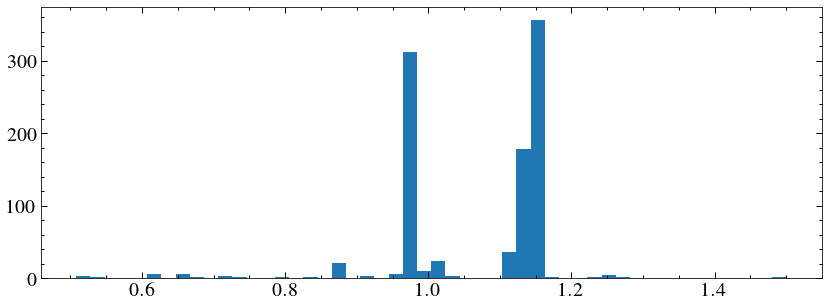

In [193]:
maxp = []
i = 0
while i < 1000:
    i +=1
    fi = np.random.normal(percent_change, ne)
    freqi, poweri = LombScargle(time, fi, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.5, samples_per_peak=10)
    maxp.append(1 / freqi[np.argmax(poweri)])
plt.hist(maxp, bins=50)


In [194]:
np.mean(maxp), np.median(maxp), np.std(maxp)

(1.0645899367271532, 1.1391573255285716, 0.11299339078734513)

In [220]:
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

In [221]:
lc = lk.LightCurve(time=data['TIME'], flux=data['PDCSAP_FLUX'], flux_err=data['PDCSAP_FLUX_ERR'])

/home/david/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


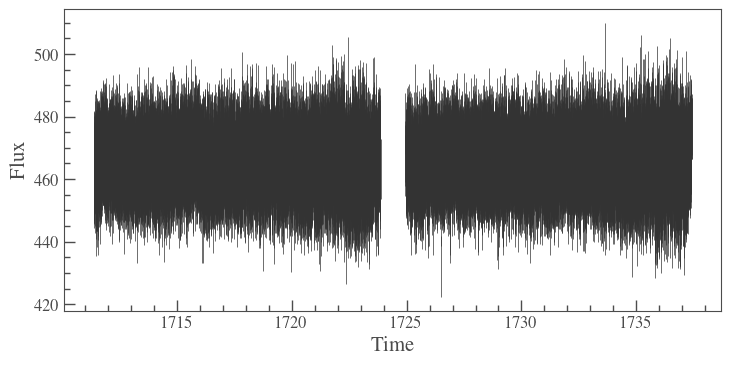

In [222]:
lc.errorbar()

<Quantity 1.1443731 d>

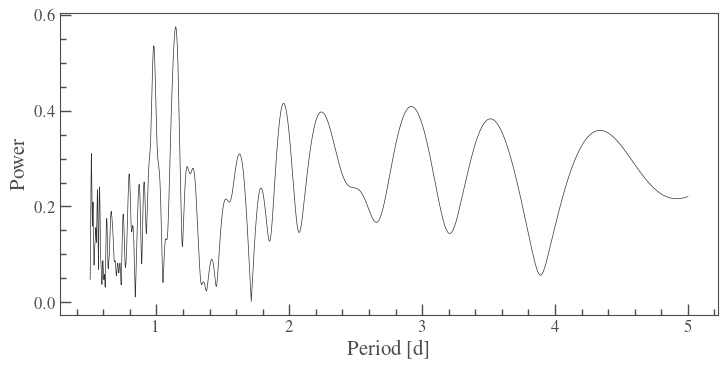

In [241]:
#lc = lc.remove_nans()
pg = lc.to_periodogram(oversample_factor=100,minimum_period=0.5*u.day, maximum_period=5*u.day,)
pg.plot();
pg.period_at_max_power

In [238]:
pg.period_at_max_power

<Quantity 1.14689275 d>

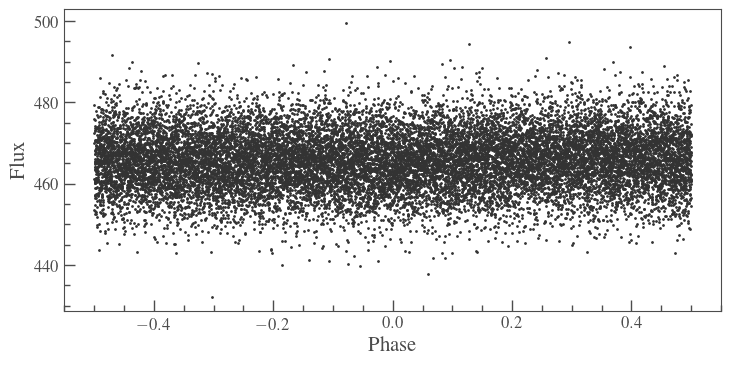

In [242]:
lc.fold(pg.period_at_max_power).scatter();

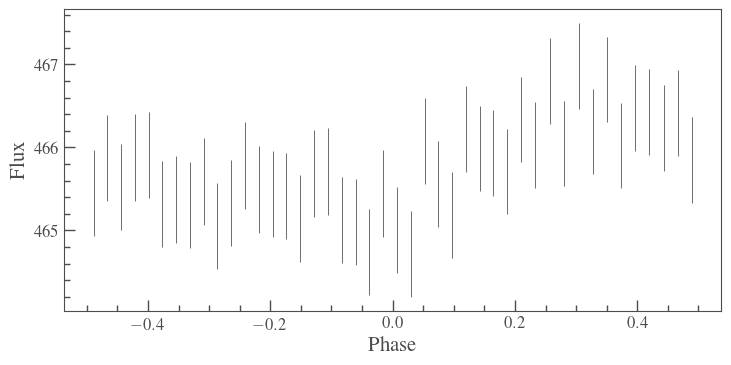

In [271]:
#lcb = lc.bin(700)
lc.fold(pg.period_at_max_power).bin(400).errorbar();
#lcb.scatter()

In [272]:
pg.max_power

<Quantity 0.57514686>